# Projektarbeit Data Analytics

Sebastian Jana,
Sophie Jana

## Inhaltsverzeichnis
<a id ="inhaltsverzeichnis"></a>

[1. Aufgabe](#aufgabe1)

2. Aufgabe

3. Aufgabe

4. Aufgabe
5. Aufgabe

[6. Aufgabe](#aufgabe6)

[7. Quellenverzeichnis](#quellenverzeichnis)




### Aufgabe 1 (Datenvorbereitung)
<a id = "aufgabe1"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Einlesen der CSV Dateien, welche die Stromerzeugungsdaten und die Börsenstrompreise enthalten, als Dataframe df_hourly.

Nach dem ersten Zusammenführen haben wir festgestellt, dass die Datumsspalte je nach CSV-Datei unterschiedliche Namen für Sommerzeit und Winterzeit hat. Dies führt dazu, dass beim Zusammenführen zwei separate Spalten entstehen. Um dies zu vermeiden, prüfen wir bereits beim Einlesen der Dateien die Spaltennamen und führen sie zu einer einheitlichen Spalte „Datum“ im df_hourly zusammen


In [27]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string

In [28]:
# Sources for reading csv files from one folder[1],[2]
path = './Daten/Strompreisdaten'
# List all files (.csv) in the given path
csv_files = glob.glob(os.path.join(path, "*csv"))

df_list = []
for i in range(len(csv_files)):
    try:
        df_temp = pd.read_csv(csv_files[i], sep = ",")
        for column in df_temp.columns:
            # Combine the date columns, by getting rid of the naming difference in csv source
            if 'Datum (MESZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MESZ)':'Datum'})
            elif 'Datum (MEZ)' in column:
                df_temp = df_temp.rename(columns = {'Datum (MEZ)':'Datum'})
        df_list.append(df_temp)
    except Exception as err: 
        print("Fehler beim Einlesen des Files: ", err)
    
df_hourly = pd.concat(df_list)
df_hourly

,Datum,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh)
0,2019-12-30 00:00:00,14233.89,29930.56,11.07
1,2019-12-30 01:00:00,14154.34,30166.97,11.84
2,2019-12-30 02:00:00,13251.87,30427.25,6.16
3,2019-12-30 03:00:00,13186.11,31289.24,1.40
4,2019-12-30 04:00:00,13045.57,32203.27,4.81
...,...,...,...,...
211,2024-12-31 19:00:00,21383.15,38916.54,67.77
212,2024-12-31 20:00:00,18556.76,40027.68,35.56
213,2024-12-31 21:00:00,15780.62,40653.76,15.70
214,2024-12-31 22:00:00,14930.74,40116.86,9.06


b) Zur besseren anschließenden Analyse überführen wir die Datumsspalte (vorher dytpe object) in ein Date-Time-Format. Überprüfung, ob nach der Konvertierung invalide Datumswerte existieren, was nicht der Fall ist.
Alle anderen Spalten haben den dtype float64 und werden so belassen.
Entfernung aller Datensätze, die nicht im Betrachtungszeitraum liegen (2020-2024).

In [29]:
print(df_hourly.shape)
# Converting the column "Datum" from dtype object to DateTime format
# Invalid values are converted to NaT (Not a Time)
# Source: [3]
df_hourly['Datum'] = pd.to_datetime(df_hourly['Datum'], errors="coerce")
print(df_hourly.dtypes)


print(df_hourly['Datum'].isna().any())

# Erstelle eine Spalte mit dem Jahr aus der Datumsspalte
df_hourly['Jahr'] = df_hourly['Datum'].dt.year

# Filter: Jahre außerhalb des Bereichs 2020–2024
df_false_year = df_hourly[(df_hourly['Jahr'] < 2020) | (df_hourly['Jahr'] > 2024)]

print(df_false_year.shape)
df_false_year
#df_hourly = df_hourly[(df_hourly['Datum'] >= '2020-01-01') & (df_hourly['Datum'] <= '2024-12-31')]
#df_hourly.shape
#df_hourly


(43896, 4)
Datum                                datetime64[ns]
Leistung nicht erneuerbar (MW)              float64
Leistung erneuerbar (MW)                    float64
Day Ahead Auktion Preis (EUR/MWh)           float64
dtype: object
False
(48, 5)


,Datum,Leistung nicht erneuerbar (MW),Leistung erneuerbar (MW),Day Ahead Auktion Preis (EUR/MWh),Jahr
0,2019-12-30 00:00:00,14233.89,29930.56,11.07,2019
1,2019-12-30 01:00:00,14154.34,30166.97,11.84,2019
2,2019-12-30 02:00:00,13251.87,30427.25,6.16,2019
3,2019-12-30 03:00:00,13186.11,31289.24,1.40,2019
4,2019-12-30 04:00:00,13045.57,32203.27,4.81,2019
5,2019-12-30 05:00:00,14504.05,32795.80,16.43,2019
6,2019-12-30 06:00:00,15723.80,33329.26,26.90,2019
7,2019-12-30 07:00:00,17142.23,34181.73,30.38,2019
8,2019-12-30 08:00:00,17647.28,35692.01,32.04,2019
9,2019-12-30 09:00:00,17744.92,38669.40,31.90,2019


c) Beurteilung der Datenqualität und notwenige Datenbereinigungsschritte

### Aufgabe 6 (Analyse von Stromtarif-Angeboten für Endkunden)
<a id = "aufgabe6"></a>

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)

a) Führen Sie die gegebenen Preisvergleichdaten in einem DataFrame namens df_cust zusammen. Exportieren Sie diesen als CSV-Datei namens prices_customers.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch. Verwerfen Sie bitte zur Minimierung der Dateigröße alle Spalten, die im weiteren Verlauf nicht mehr verwendet werden. Kommentieren Sie nun den Code zur Datensatzgenerierung aus und lesen Sie die CSV-Datei in den DataFrame df_cust erneut aus dieser Datei ein.


In [30]:
'''
path = './Daten/Endkundenpreise/'

def extract_date_from_filepath(file):
    file = file.replace(path, "")
    # Concatenate the date out of fixed year 2024 and month/day from folder name
    return "2024-" + file[0:5]

def extract_data_from_json(file):
    assert file.endswith(".json"), "Keine json-Datei uebergeben"
    try:
        # Read and load the json file
        df_temp = pd.read_json(json_files[i])
        # Transpose the table: convert the rows to columns
        df_temp = df_temp.T
        # Add date from filename as column
        df_temp['Datum'] = extract_date_from_filepath(file)
        
        return df_temp
    except:
        print("Datei konnte nicht gelesen werden.")

def drop_unnecessary_columns(df):
    columns_to_drop = ['Postleitzahl', 'Jahresverbrauch', 'Abschlagszahlung', 'Verlängerung', 'Kündigungsfrist', 'Grundpreis', 'Arbeitspreis', 'Preisgarantie', 'Grundpreisrabatt:', 'Neukundenbonus', 'Sofortbonus', 'Arbeitspreisrabatt', 'Zusätzlicher Aktionsbonus', 'Blitzbonus', 'Abschlagsrabatt', 'Grundpreisrabatt', 'Winterprämie']
    return df.drop(columns = columns_to_drop)

df_list = []
# https://www.tutorialspoint.com/python/os_listdir.htm
for folder in os.listdir(path):
    combined_path = os.path.join(path, folder, "*json")
    json_files = glob.glob(combined_path)

    for i in range(len(json_files)):
        df_temp = extract_data_from_json(json_files[i])
        df_list.append(df_temp)
        
df_cust = pd.concat(df_list)
df_cust = drop_unnecessary_columns(df_cust)
# https://www.datacamp.com/tutorial/save-as-csv-pandas-dataframe
df_cust.to_csv('prices_customers.csv', index = False, encoding='utf-8')
'''


'\npath = \'./Daten/Endkundenpreise/\'\n\ndef extract_date_from_filepath(file):\n    file = file.replace(path, "")\n    # Concatenate the date out of fixed year 2024 and month/day from folder name\n    return "2024-" + file[0:5]\n\ndef extract_data_from_json(file):\n    assert file.endswith(".json"), "Keine json-Datei uebergeben"\n    try:\n        # Read and load the json file\n        df_temp = pd.read_json(json_files[i])\n        # Transpose the table: convert the rows to columns\n        df_temp = df_temp.T\n        # Add date from filename as column\n        df_temp[\'Datum\'] = extract_date_from_filepath(file)\n        \n        return df_temp\n    except:\n        print("Datei konnte nicht gelesen werden.")\n\ndef drop_unnecessary_columns(df):\n    columns_to_drop = [\'Postleitzahl\', \'Jahresverbrauch\', \'Abschlagszahlung\', \'Verlängerung\', \'Kündigungsfrist\', \'Grundpreis\', \'Arbeitspreis\', \'Preisgarantie\', \'Grundpreisrabatt:\', \'Neukundenbonus\', \'Sofortbonus\', \'

b) Bereiten Sie die Daten auf die weitere Analyse vor, indem Sie geeignete Datentransformations- und -bereinigungsschritte durchführen.

In [31]:
df_cust = pd.read_csv('prices_customers.csv')
print("Zeilen vor Bereinigung:", df_cust.shape[0])

df_cust['Datum'] = pd.to_datetime(df_cust['Datum'])

def combine_price_columns(row):
    if pd.isna(row['Preis im 1. Jahr*']):
        return row['Preis im 1. Jahr']
    return row['Preis im 1. Jahr*']

def replace_string_from_row(row, column, string, string_to_replace_with):
    if pd.isna(row[column]):
        return row[column]
    if string in row[column]:
        return row[column].replace(string, string_to_replace_with)
    return row[column]

# Combine the two price columns into one
df_cust['Preis'] = df_cust.apply(combine_price_columns, axis = 1)
df_cust = df_cust.drop(columns = ['Preis im 1. Jahr*', 'Preis im 1. Jahr'])
# Drop rows with NaN as Preis, because those rows aren't viable for a comparison later on
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
df_cust = df_cust.dropna(subset=['Preis'])

df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monate", ""), axis=1)
df_cust['Vertragslaufzeit'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Vertragslaufzeit', " Monat", ""), axis=1)
# Fill NaN values, so that dtype can be converted to int
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].fillna(0)
df_cust['Vertragslaufzeit'] = df_cust['Vertragslaufzeit'].astype(int)

df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', " €/Monat", ""), axis=1)
# Change decimal comma, to decimal point for float conversion
df_cust['Preis'] = df_cust.apply(lambda row: replace_string_from_row(row, 'Preis', ",", "."), axis=1)
df_cust['Preis'] = df_cust['Preis'].astype(float)
df_cust = df_cust.rename(columns = {'Preis' : 'Preis im 1. Jahr/ pro Monat in €', 'Vertragslaufzeit' : 'Vertragslaufzeit in Monaten'})

print("Zeilen nach Bereinigung:", df_cust.shape[0])



Zeilen vor Bereinigung: 256340
Zeilen nach Bereinigung: 255663


c) Wie viele verschiedene Tarife wurden insgesamt angeboten? Zu wie vielen Tagen sind pro Stadt Daten vorhanden? Wie viele verschiedene Anbieter haben insgesamt Tarife angeboten?

In [32]:
unique_tariffe = df_cust['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe))

# Occuring Städte in the DataSet
number_of_total_cities = len(df_cust['Stadt'].unique())

# Group with any aggregation to get all unique Datum/Stadt combination entries
grouped_date_city = df_cust.groupby(['Datum', 'Stadt']).agg(Count=('Stadt', 'count')).reset_index()
# Group and count how many different Stadt rows there are for each given date
grouped_date = grouped_date_city.groupby( ['Datum'])['Stadt'].count()
# Filter out the dates that don't have an entry for every Stadt of the DataSet
filtered_dates = grouped_date[grouped_date == number_of_total_cities]
print("Daten für alle Städte sind an", len(filtered_dates), "Tagen vorhanden")

unique_anbieter = df_cust['Anbieter'].unique()
print("Anzahl der Anbieter die insgesamt Tarife angeboten haben:", len(unique_anbieter))

Anzahl verschiedender Tarife: 112
Daten für alle Städte sind an 312 Tagen vorhanden
Anzahl der Anbieter die insgesamt Tarife angeboten haben: 78


d) Ermitteln Sie, welche unterschiedlichen Tarife in Amberg angeboten wurden und visualisieren Sie exemplarisch für die Stadt Amberg den Füllgrad der Daten. Erstellen Sie dazu eine HeatMap, aus der hervorgeht, an welchen Tagen es zu welchen der ermittelten Tarife Angebotsdaten gab.

Anzahl verschiedender Tarife: 77


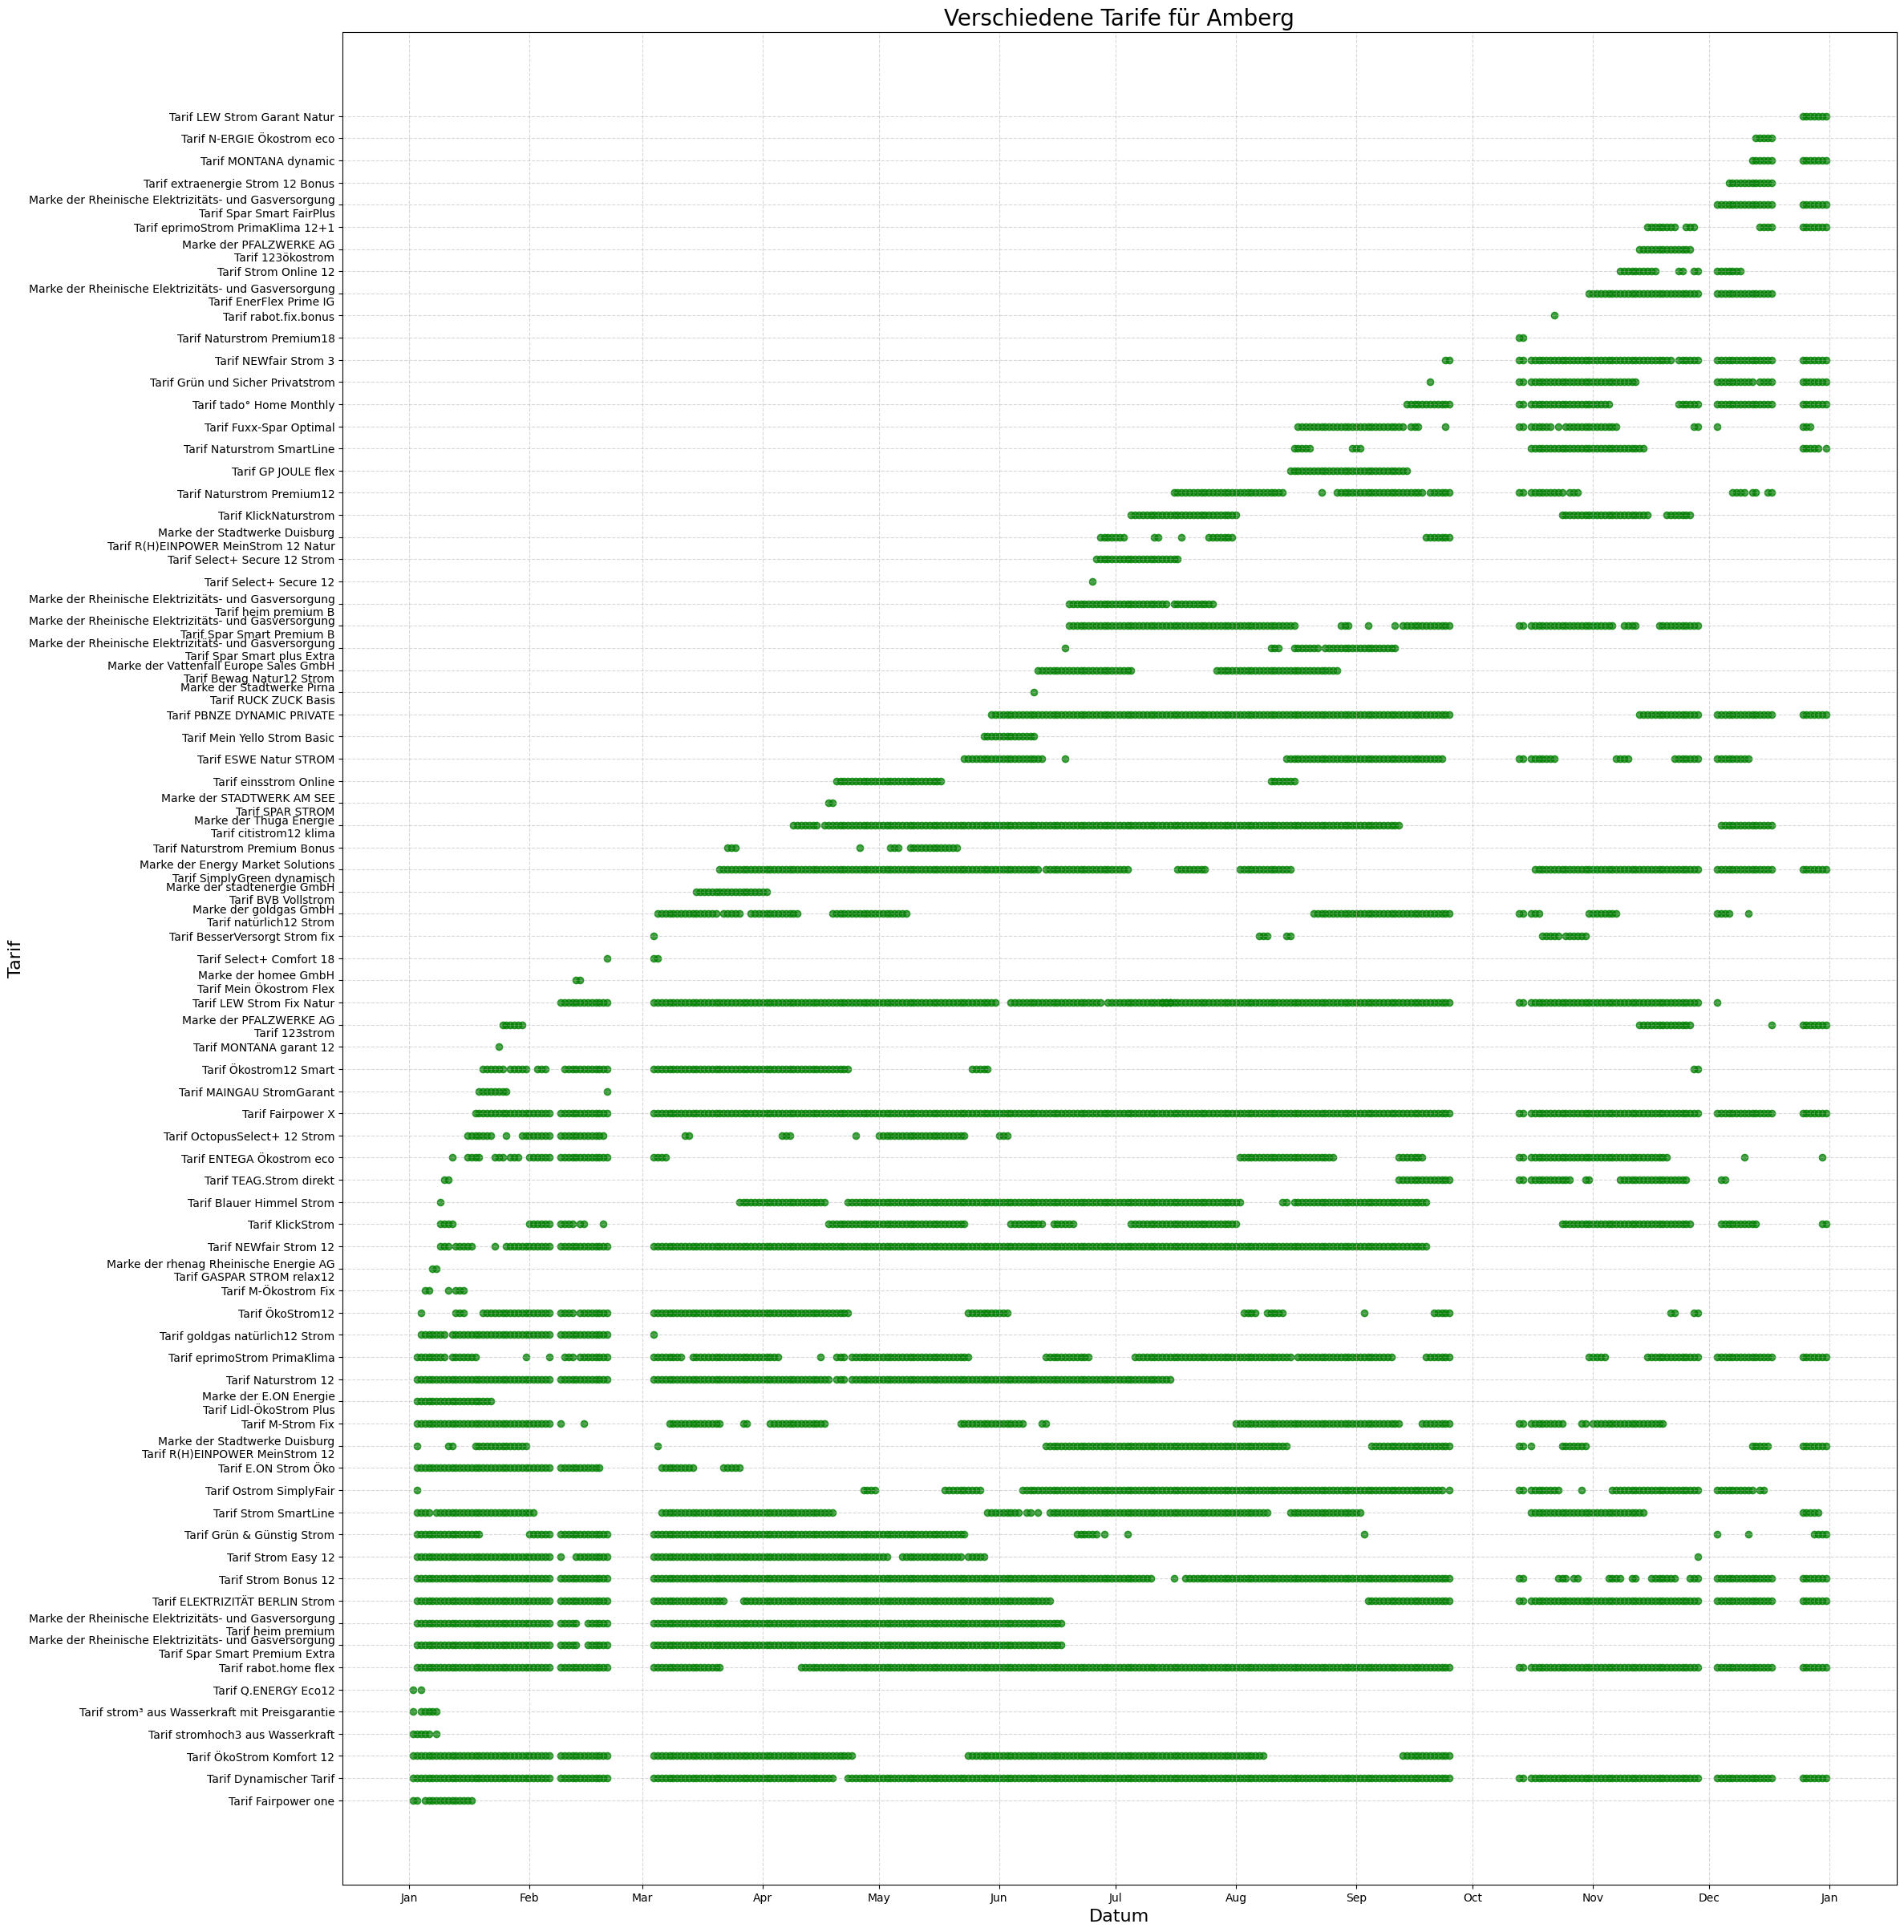

In [33]:
df_amberg = df_cust[df_cust['Stadt'] == 'Amberg']

unique_tariffe_amberg = df_amberg['Tarif'].unique()
print("Anzahl verschiedender Tarife:" , len(unique_tariffe_amberg))

plt.figure(figsize=(25, 30))
# HeatMap: green = the Tariff is offered for the given day, none/white = no offering 
plt.scatter(df_amberg['Datum'], df_amberg['Tarif'], color ='green', alpha=0.75)

# https://stackoverflow.com/questions/57796673/switching-month-numbers-to-month-names-on-x-axis-of-histogram-matplotlib
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

plt.xlabel('Datum', fontsize=16) 
plt.ylabel('Tarif', fontsize=16)
plt.title('Verschiedene Tarife für Amberg', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


e) Visualisieren Sie die durchschnittliche Preisentwicklung im Verlauf des Jahres 2024 über alle Tarife und Orte hinweg. Berücksichtigen Sie dabei nur Tarife, bei denen die Vertragslaufzeit mindestens 12 Monate beträgt. Verwenden Sie dazu den Preis im 1. Jahr, der den monatlichen Preis unter Berücksichtigung des Grundpreises, des Arbeitspreises und von Bonuszahlungen o.ä. enthält. Untersuchen Sie anschließend den Zusammenhang zum Börsenstrompreis, indem Sie geeignete Kenngrößen berechnen und weitere Diagramme erstellen.

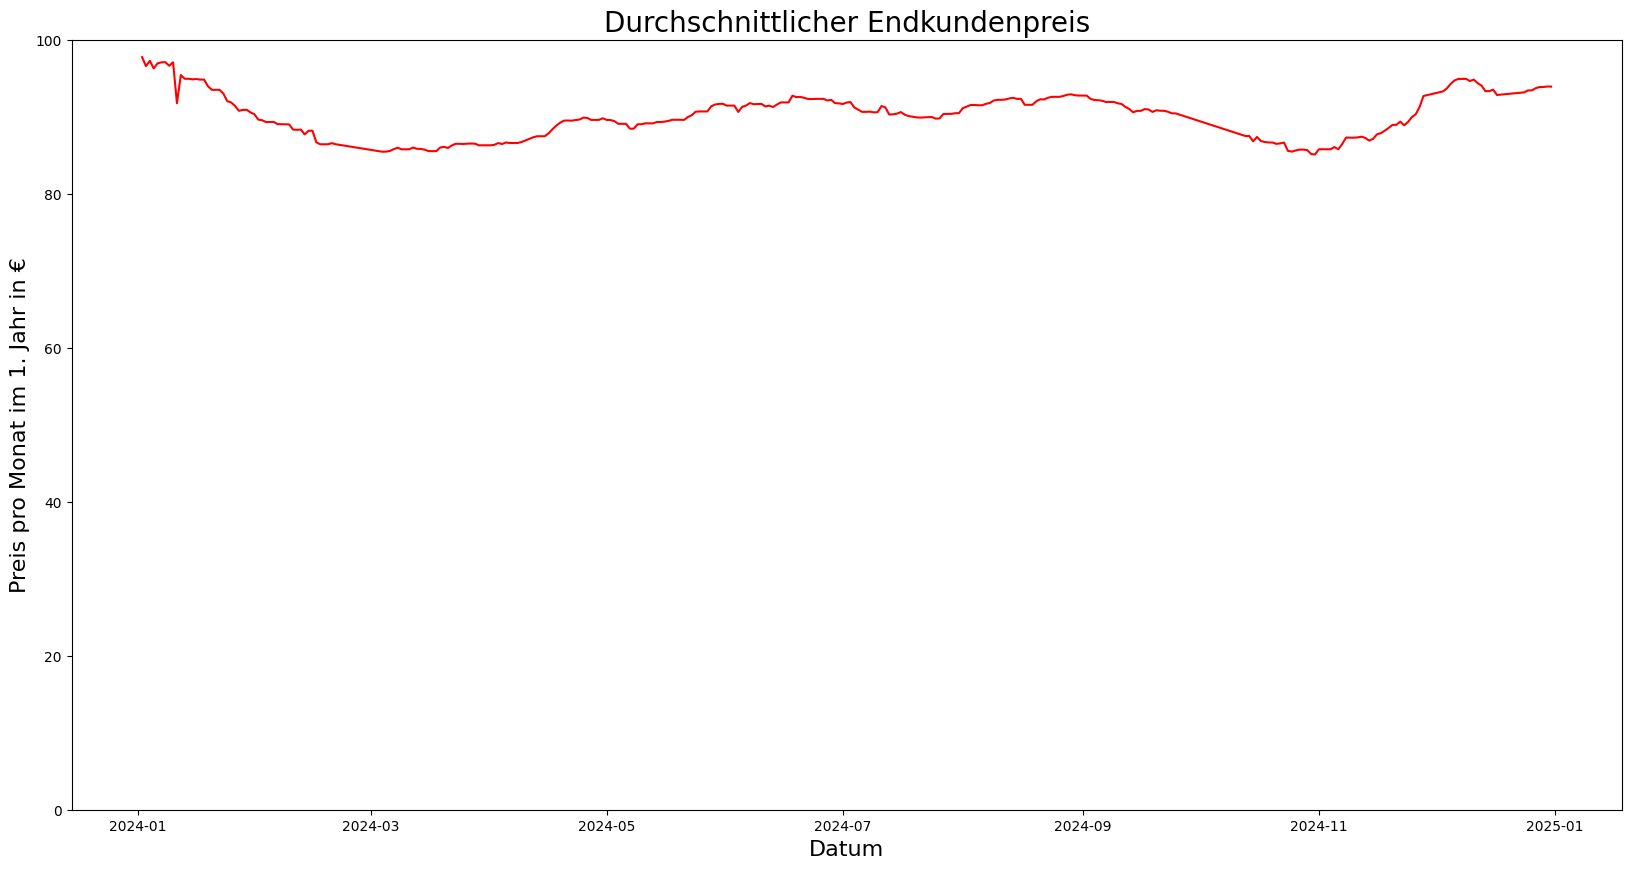

In [34]:
filtered_12_months = df_cust[df_cust['Vertragslaufzeit in Monaten'] >= 12]
df_mean_prices = filtered_12_months.groupby(['Datum']).agg(Mean =('Preis im 1. Jahr/ pro Monat in €', 'mean')).reset_index()

plt.figure(figsize=(20, 10))
plt.plot(df_mean_prices['Datum'], df_mean_prices['Mean'], label = 'Line', color = 'red')

#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
# Start line plot at 0, to not overdramatize the change in consumer price
plt.ylim(bottom = 0, top = 100)

plt.xlabel('Datum', fontsize=16) 
plt.ylabel('Preis pro Monat im 1. Jahr in €', fontsize=16)
plt.title('Durchschnittlicher Endkundenpreis', fontsize=20)

plt.show()

i) Im Merkmal Anbieter befinden sich kurze Beschreibungen der Anbieter und der Tarife. Erstellen Sie mit Hilfe des Pakets WordCloud eine Wortwolke für die Anbieter-Beschreibungen und untersuchen Sie, welche Schlagworte besonders häufig auftreten.

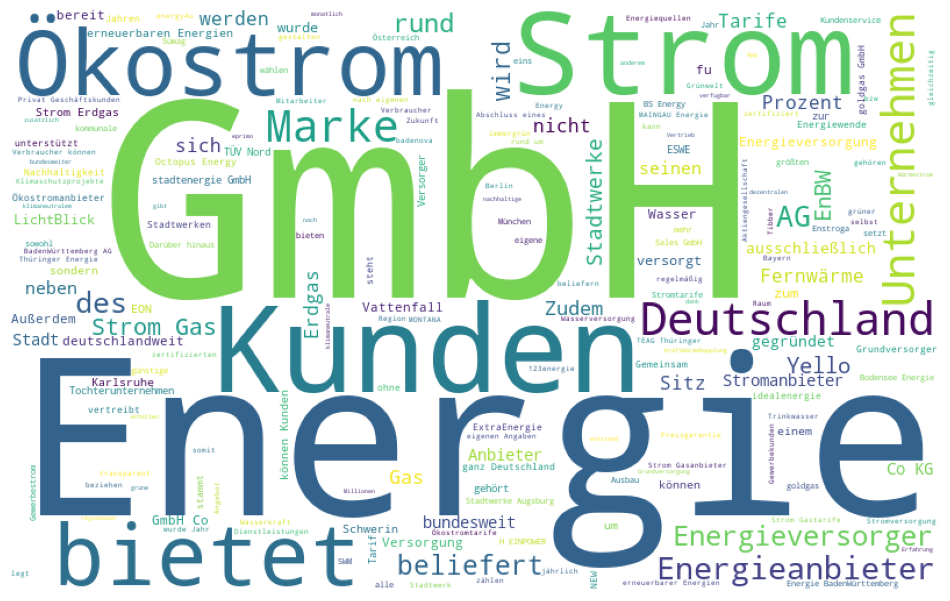

In [37]:
def remove_punctuation_from_anbieter(anbieter):
    punctuations = [".",",","/","&","-","_",":",";"]
    for p in punctuations:
        anbieter = anbieter.replace(p, "")
    return anbieter
    
def remove_non_buzzwords_from_anbieter(anbieter):
    anbieter_words = anbieter.split() # Isolate each word of Anbieter

    words_to_remove = [
        'der', 'die', 'das', 'und', 'ein', 'eine', 'einen', 'mit', 'ist', 'den', 'dem', 'zu', 'von', 'vom', 
        'auf', 'im', 'an', 'für', 'am', 'als', 'es', 'aber', 'auch', 'aus', 'bei', 'dass', 'um'
        'du', 'er', 'sie', 'wir', 'ihr', 'ihnen', 'ihm', 'euch', 'mir', 'mich', 
        'mein', 'meine', 'dein', 'deine', 'sein', 'seine', 'ihr', 'ihre', 
        'noch', 'schon', 'oder', 'so', 'wie', 'was', 'wer', 'wenn', 'beim'
        'warum', 'weil', 'dann', 'doch', 'nur', 'diese', 'dieser', 'dieses', 
        'jeder', 'jede', 'jedes', 'keiner', 'keine', 'kein', 'welche', 'welcher', 
        'man', 'damit', 'über', 'unter', 'haben', 'hat', 'sein', 'sind', 'war', 'waren', 
        'dabei', 'in', 'seit', 'durch', 'ihren', 'einer', 'sowie'
    ]

    filtered_words = []
    
    for word in anbieter_words:
        if word.lower() not in words_to_remove:
            filtered_words.append(word)

    # https://www.w3schools.com/python/ref_string_join.asp
    return ' '.join(filtered_words)

unique_anbieter_strs = df_cust['Anbieter'].unique()

for i in range(len(unique_anbieter_strs)):
    unique_anbieter_strs[i] = remove_punctuation_from_anbieter(unique_anbieter_strs[i])
    unique_anbieter_strs[i] = remove_non_buzzwords_from_anbieter(unique_anbieter_strs[i])

# Create one String out of all different Anbieter 
combined_text = ' '.join(unique_anbieter_strs)

wordcloud = WordCloud(width=800, height=500, background_color='white').generate(combined_text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')  # No axes for the word cloud
plt.show()


### Quellenverzeichnis
<a id = "quellenverzeichnis"></a>

[1] https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/

[2] https://statistikguru.de/python/python-auflisten-dateien-verzeichnis.html

[3] https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

[Zurück zum Inhaltsverzeichnis](#inhaltsverzeichnis)